# Importing

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('future.no_silent_downcasting', True)

from joblib import Parallel, delayed
from itertools import product

# Loading Data

In [2]:
data = pd.read_csv('data/coins.csv', index_col=0, parse_dates=True)
data.head()

BTC      XRP        BNB      DOGE       ADA       TRX  \
Date                                                                         
2018-01-01  14093.606831  2.31012   8.828099  0.009091  0.747140  0.051654   
2018-01-02  15321.932852  2.45529   9.090393  0.009335  0.807430  0.080893   
2018-01-03  15583.885538  3.12571   9.886323  0.009592  1.075401  0.098107   
2018-01-04  15976.365194  3.22005   9.675758  0.010098  1.179347  0.218139   
2018-01-05  18336.922980  2.93138  16.488523  0.013841  1.077821  0.231673   

                   LTC      LINK          BCH        EOS  ...       UTK  \
Date                                                      ...             
2018-01-01  230.462120  0.751033  2426.970077   7.672278  ...  0.467207   
2018-01-02  255.048185  0.689388  2627.026940   9.504036  ...  0.647065   
2018-01-03  248.042194  0.704623  2630.511811  10.090184  ...  0.896774   
2018-01-04  244.834372  1.036826  2458.894372  11.713284  ...  0.874131   
2018-01-05  254.138525  0.996575  2551.321685   9.673192  ...  0.762206   

                PIVX       SYS       REQ       FUN       VIB      NULS  IDEX  \
Date                                                                           
2018-01-01  10.68950  0.783623  0.867352  0.086325  0.455327  2.267259   NaN   
2018-01-02  11.55500  0.817777  0.809224  0.088933  0.464458  2.510494   NaN   
2018-01-03  10.92360  0.798803  0.795348  0.106564  0.584170  3.696732   NaN   
2018-01-04  10.58120  0.784280  0.826834  0.178514  0.698240  4.788923   NaN   
2018-01-05   9.95117  0.748309  0.761799  0.161191  0.585847  5.659994   NaN   

            MDT  BORG  
Date                   
2018-01-01  NaN   NaN  
2018-01-02  NaN   NaN  
2018-01-03  NaN   NaN  
2018-01-04  NaN   NaN  
2018-01-05  NaN   NaN  

[5 rows x 86 columns]

- Here we have the data $$P^A_t, P^B_t$$ 
    - where $P^x_t$ is the price of stock $x \in \{A,B\}$ at time $t$

- We take $$p_t = log(P_t)$$ 
    - as the log price

# Train and test set

In [3]:
train_end = pd.Timestamp('2019-12-31') # end of training set

In [4]:
train = data.loc[:train_end] # training set 
test  = data.loc[train_end + pd.Timedelta(days=1):] # testing set

# Selecting Pairs

- we take the rolling correlation as $$C_t = corr(p^A_t, p^B_t)$$
- our selection criterion is for each coin A pick the top n coins that have $|C_t| ≥ 0.9$

In [5]:
def pairs_selection(data, n=5, threshold=0.9):

    """
    for each coin selects top n correlated coins from absolute correlation matrix
    """
        
    # calculate absolute correlation matrix
    corr = data.corr().abs()

    # set to hold unique pairs and dict to hold top n pairs for each coin 
    pairs = set()
    top_pairs = {}

    # loop through each coin
    for coin in corr.columns:

        # drop self correlations
        series = corr[coin].drop(index=coin)

        # keep correlations above the threshold 
        strong = series[series >= threshold]

        # keep top n 
        top_n = strong.nlargest(n)

        # record for this coin and global set
        top_pairs[coin] = top_n.index.tolist()
        pairs.update((coin, other) for other in top_n.index)

    # sort and return 
    pairs_list = sorted(pairs)
    
    return pairs_list

# Indicators and Positions

- We use the OLS formula $$p^A_t = \alpha_t + \beta_t p^B_t + \epsilon_t$$

- Where $$\beta_t = \frac{cov_t(p^A_t, P^B_t)}{var_t(p^A_t)}$$ 
    - where $cov_t(p^A_t, P^B_t)$ is the rolling covariance of $p^A_t, p^B_t$ and $var_t(p^A_t)$ is the rolling variance of stock $p^A_t$
    - $\beta_t$ tells us how many units of coin B to long/short

- We find $\alpha_t$ by $$\alpha_t = \mu_{p^B_t} - \beta_t \mu_{p^A_t}$$
    - where $\mu_{p^A_t}, \mu_{p^B_t}$ are the rolling means of $p^A_t, p^B_t$

- And we take the Z-score as $$z = \frac{\epsilon_t - \mu_t}{\sigma_t}$$
    - where $\mu_t$ is the rolling mean of the spread and $\sigma_t$ is the rolling s.d of the spread 

In [6]:
def compute_pair_indicators(data, pairs, window=90):

    """
    For each (A, B) pair, compute rolling:
      • beta (cov/var)
      • alpha (mean_B - beta*mean_A)
      • spread (A - (beta*B + alpha))
      • z_score (spread normalised)
    """

    # empty dict to hold indicator data 
    indicators = {}

    # loop through each pair
    for pair in pairs:
        A, B = pair 

        # define the log prices 
        p_A = np.log(data[A].replace(0, np.nan).ffill())
        p_B = np.log(data[B].replace(0, np.nan).ffill())

        # define rolling covariance and variance
        cov_t = p_A.rolling(window, min_periods=1).cov(p_B)
        var_t = p_A.rolling(window, min_periods=1).var()

        # calculate beta and alpha
        beta_t = cov_t / var_t
        alpha_t = p_B.rolling(window, min_periods=1).mean() - beta_t * p_A.rolling(window, min_periods=1).mean()

        # calculate the spread
        spread = p_A - (beta_t * p_B + alpha_t)

        # calculate mean and std of the spread
        mu = spread.rolling(window, min_periods=1).mean()
        sigma = spread.rolling(window, min_periods=1).std()

        # calculate z-score
        z_score = (spread - mu) / sigma
        
        # store the indicators in the dict
        indicators[(pair, 'beta')] = beta_t
        indicators[(pair, 'alpha')] = alpha_t
        indicators[(pair, 'spread')] = spread
        indicators[(pair, 'z_score')] = z_score
    
    # convert the dict to df 
    indicators = pd.DataFrame(indicators)
    return indicators

- Entry
    - We long A and short B when $$z_t < -1$$
    - We short A and long B when $$z_t > 1$$

- Exit
    - close the position when either $z_t > thresh$ or $z_t < -thresh$ 
        - for some threshold

In [7]:
def gen_positions(indics, pairs, dataset, exit=0.5, entry=1.0):

    """
    Build and normalise portfolio positions from z-score indics

    For each pair:
      • z >  1 -> short A, long β·B  
      • z < -1 -> long  A, short β·B  
      • |z| ≤ threshold -> exit

    Positions are forward filled and scaled so that positions sum to 1
    """

    # empty positions table
    positions = pd.DataFrame(index=indics.index, columns=dataset.columns, dtype=float)

    # loop through pairs
    for pair in pairs:
        A, B = pair

        # get z score
        z_score = indics[(pair, 'z_score')]
        # get beta
        beta = indics[(pair, 'beta')]
        
        # build boolean masks 
        mask_long  =   z_score >  entry
        mask_short =   z_score < - entry
        mask_exit  =  z_score.abs() <= exit

        # indics for long and short trades
        # A positions
        positions.loc[mask_long,  A] = -1   # entry: short A when z >  1
        positions.loc[mask_short, A] =  1   # entry: long  A when z < -1
        positions.loc[mask_exit,  A] =  0   # exit:   close A when |z| ≤ threshold

        # B positions
        positions.loc[mask_long,  B] =  beta[mask_long].values   # entry: long  β·B when z >  1
        positions.loc[mask_short, B] = -beta[mask_short].values  # entry: short β·B when z < -1
        positions.loc[mask_exit,  B] =  0                         # exit:   close B when |z| ≤ threshold

    # ffill positions - carry forward open trades until you hit an exit signal
    positions = positions.ffill()
    # normalise all positions to sum to 1 (fully invested)
    positions = positions.divide(positions.abs().sum(axis=1), axis=0).fillna(0)
    return positions

# Plotting Z Score and Signals

In [8]:
def plot_pair_signals(indicators, pair, exit, entry=1.0):

    # extract data
    z = indicators[(pair, 'z_score')]
    dates = z.index
    price_A = np.log(data[pair[0]].loc[dates])
    price_B = np.log(data[pair[1]].loc[dates])

    # entry/exit signals
    long_idx  = z[z >  entry]
    short_idx = z[z < -entry]
    exit_idx  = z[z.abs() <= exit]

    # figure with secondary y axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Prices on primary y
    fig.add_trace(go.Scatter(x=dates, y=price_A, name=pair[0], line=dict(color='blue')), secondary_y=False)
    fig.add_trace(go.Scatter(x=dates, y=price_B, name=pair[1], line=dict(color='orange')), secondary_y=False)

    # Z-score on secondary y
    fig.add_trace(go.Scatter(x=dates, y=z, name='z-score', line=dict(color='black')), secondary_y=True)

    # threshold lines for secondary y
    fig.add_hline(y= entry, line_dash="dash", line_color="green", yref="y2")
    fig.add_hline(y=-entry, line_dash="dash", line_color="green", yref="y2")
    fig.add_hline(y= exit, line_dash="dot",  line_color="red",   yref="y2")
    fig.add_hline(y=-exit, line_dash="dot",  line_color="red",   yref="y2")

    # markers for buy/sell on secondary y 
    fig.add_trace(go.Scatter(x=long_idx.index, y=long_idx.values, mode='markers',
        name='Long', marker_symbol='triangle-up', marker_color='green',
        marker_size=8
    ), secondary_y=True)

    fig.add_trace(go.Scatter(
        x=short_idx.index, y=short_idx.values, mode='markers',
        name='Short', marker_symbol='triangle-down', marker_color='red',
        marker_size=8
    ), secondary_y=True)

    fig.add_trace(go.Scatter(
        x=exit_idx.index, y=exit_idx.values, mode='markers',
        name='Exit', marker_symbol='circle', marker_color='orange',
        marker_size=8
    ), secondary_y=True)

    # layout
    fig.update_layout(
        height=500, width=900,
        title_text=f"{pair[0]}/{pair[1]} Log Prices & Z-Score Signals",
        hovermode="x unified"
    )
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Log Price", secondary_y=False)
    fig.update_yaxes(title_text="Z-Score", secondary_y=True)

    fig.show()

# Performance Functions

- simple daily returns $$r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$

In [9]:
coin_returns = data.pct_change().shift(-1)

In [10]:
def turnover(positions):
    
    """
    Calculate the turnover of the portfolio positions (absolute change in positions from one day to the next)
    """
    turnover = positions.diff().abs().sum(axis=1)
    return turnover

- Sharpe Ratio $$SR = \frac{E[r_t]}{\sigma(r_t)} \times N^{1/2}$$
    - where $N$ is the number of trading days (252)

In [11]:
def calc_sharpe_ratio(returns):
    
    """
    Calculate the Sharpe ratio of the portfolio returns
    """
    mean_returns = returns.mean()
    volatility = returns.std()

    if volatility == 0 or np.isnan(volatility):
        return np.nan
    return np.sqrt(252) * (mean_returns / volatility)

In [12]:
def stats(returns):

    """
    Calculate the mean, volatility, Sharpe ratio and hit rate of the portfolio returns
    """

    stats_df = {}
    stats_df['mean'] = returns.mean()*252
    stats_df['vol'] = returns.std()*np.sqrt(252)
    stats_df['sharpe'] = calc_sharpe_ratio(returns)
    stats_df['hit_rate'] = returns[returns>0].count() / returns.count()

    stats = pd.Series(stats_df)
    return stats

In [13]:
def display_stats(th, s, r, v, to, h, ht, ud):
    
    """
    Display the statistics of the strategy in a DataFrame
    """
    stats = {}
    stats['Annual Return'] = f"{(r * 100):.2f}%"  
    stats['Annual Volatility'] = f"{(v * 100):.2f}%"  
    stats['Sharpe Ratio'] = f"{s:.2f}"
    stats['Annual Turnover'] = f"{(to * 100):.2f}%"   
    stats['Hit Rate'] = f"{(h * 100):.2f}%"  
    stats['Holding Period'] = f"{ht:.1f} days"  

    stats_df = pd.DataFrame(stats, index=[f'e = {th[0]}, x = {th[1]}, upd : {ud}']).T  
    return stats_df

# Walk Forward Backtesting

In [14]:
def plot_heatmaps(sharpe, returns, hitrate, turnover, upd):
    """
    Draw a 2x2 grid of heatmaps for:
      • sharpe
      • annual returns (%)
      • hit rate (%)
      • turnover (%)
    
    Each DataFrame must have the same index (entry) and columns (exit)
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    datasets = [sharpe, returns, hitrate, turnover]
    titles   = ["Sharpe Ratio", "Annual Returns (%)", "Hit Rate (%)", "Turnover (%)"]
    
    for ax, data, title in zip(axes, datasets, titles):
        sns.heatmap(data, annot=True, fmt=".2f", ax=ax)
        ax.set_title(f'{title}, UD {upd}')
        ax.set_xlabel("exit")
        ax.set_ylabel("entry")
    
    plt.tight_layout()
    plt.show()



In [15]:
def walk_forward_backtest(data, exit, entry, upd_days):

    """
    Run a rolling walk forward backtest, training on 2 years and testing on 1 year,
    then rolling forward by upd_days
    
    """    
    # empty list for results and start and end of data time stamps 
    results = []
    start = pd.Timestamp(data.index[0])
    end_of_data = pd.Timestamp(data.index[-1])

    # run this look until we have a non full year period
    while True:
        end = start + pd.DateOffset(years=2) - pd.DateOffset(days=1)
        if end + pd.DateOffset(years=1) > end_of_data:
            break
        
        # define train and test sets 
        train = data.loc[start:end]
        test_start = end + pd.DateOffset(days=1)
        test_end = test_start + pd.DateOffset(years=1) - pd.DateOffset(days=1)
        test = data.loc[test_start:test_end]
        
        # get pairs on training set 
        pairs = pairs_selection(train)

        # get inidicators 
        combined = pd.concat([train, test], axis=0)
        indics = compute_pair_indicators(combined, pairs)
        indics = indics.loc[test.index]

        # get positions 
        positions = gen_positions(indics, pairs, test, exit, entry)

        # get gross and net returns 
        simple_rtns = test / test.shift() - 1
        gross_returns = (positions.shift() * simple_rtns).sum(axis=1)

        turn = turnover(positions)  # turnover 
        tcost = 20  # transaction costs in bpts
        net_returns = gross_returns.subtract(turn * tcost * 1e-4, fill_value=0)

        # stats for this strategy 
        s = stats(net_returns)
        s['turnover'] = turn.mean()
        s['Holding Time'] = (upd_days//2) / s['turnover']
        s['train_start'] = train.index.min()
        s['train_end'] = train.index.max()
        s['test_start']  = test.index.min()
        s['test_end']  = test.index.max()
        results.append(s)

        # roll forward by upd_days days 
        start = start + pd.DateOffset(days=upd_days)
    
    return pd.DataFrame(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   34.3s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   49.5s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   56.9s finished


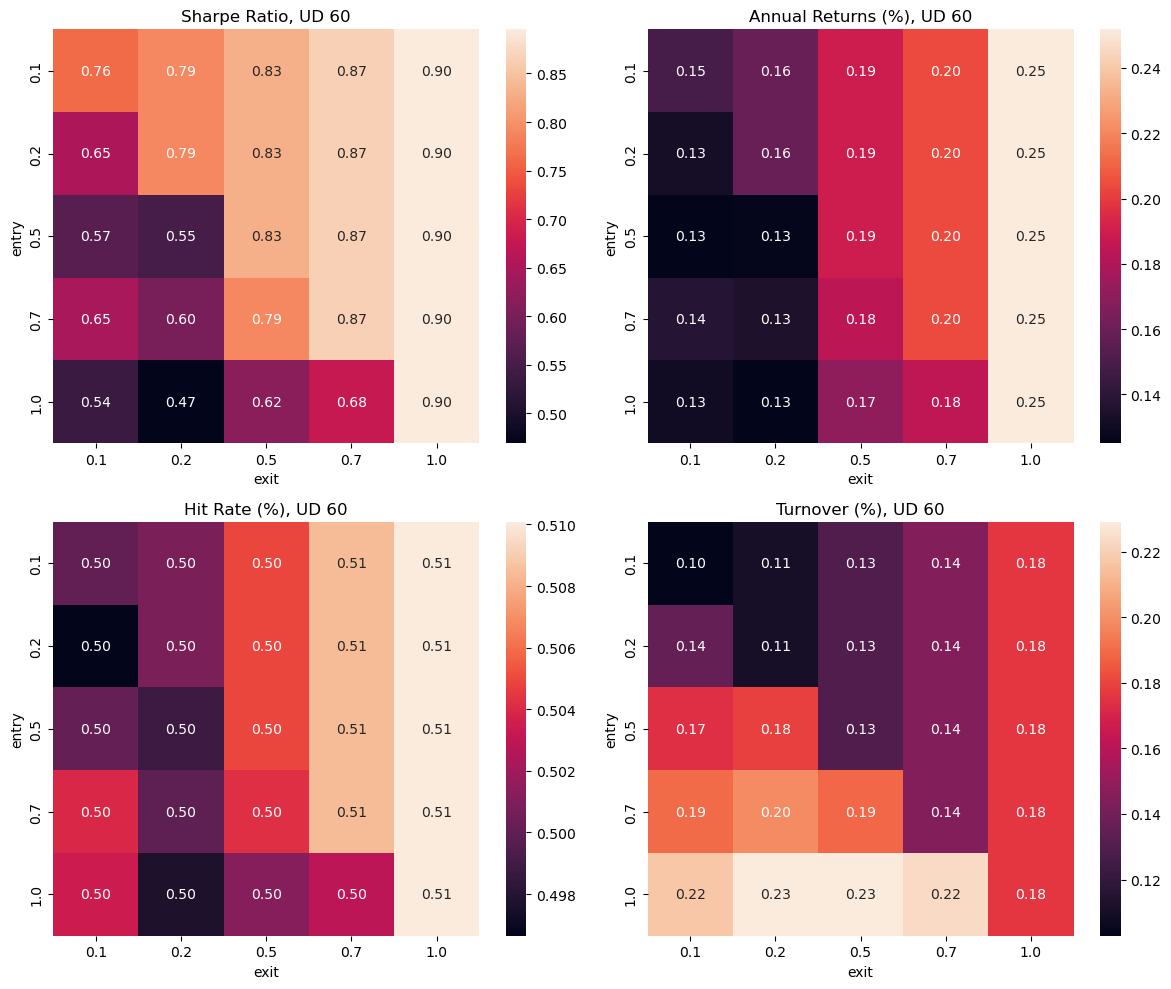

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   20.9s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   30.3s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   35.2s finished


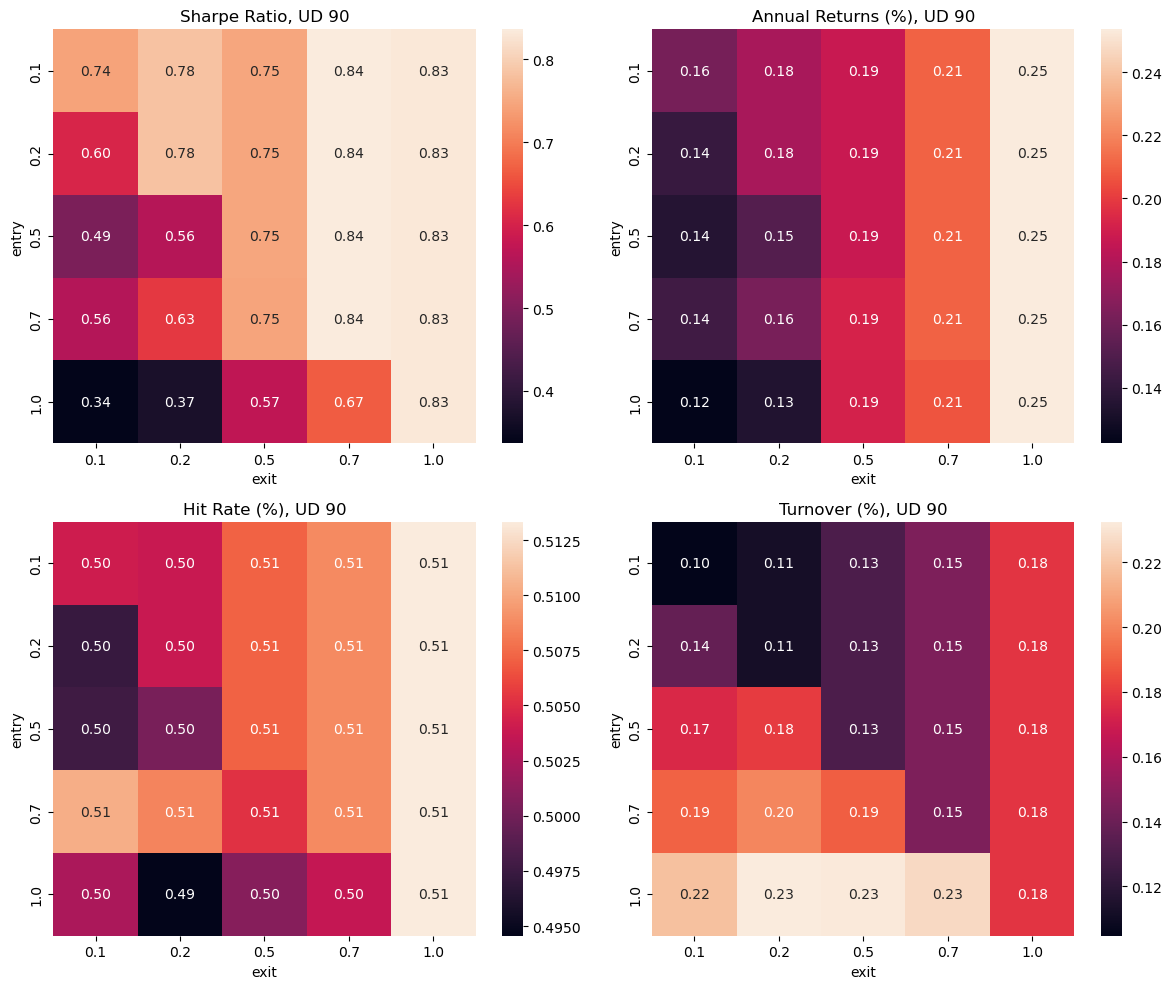

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   10.9s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   17.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   19.8s finished


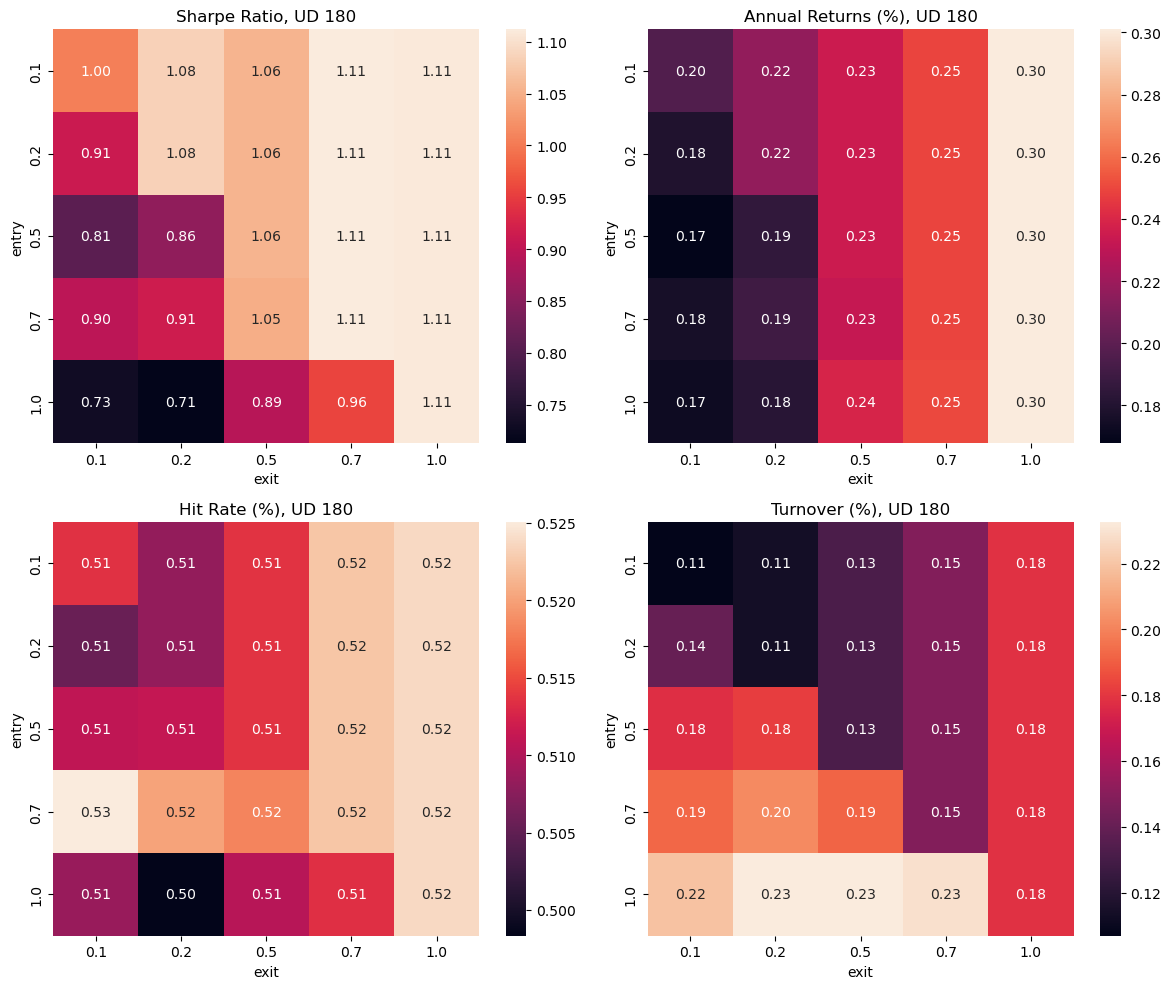

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    5.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    7.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.3s finished


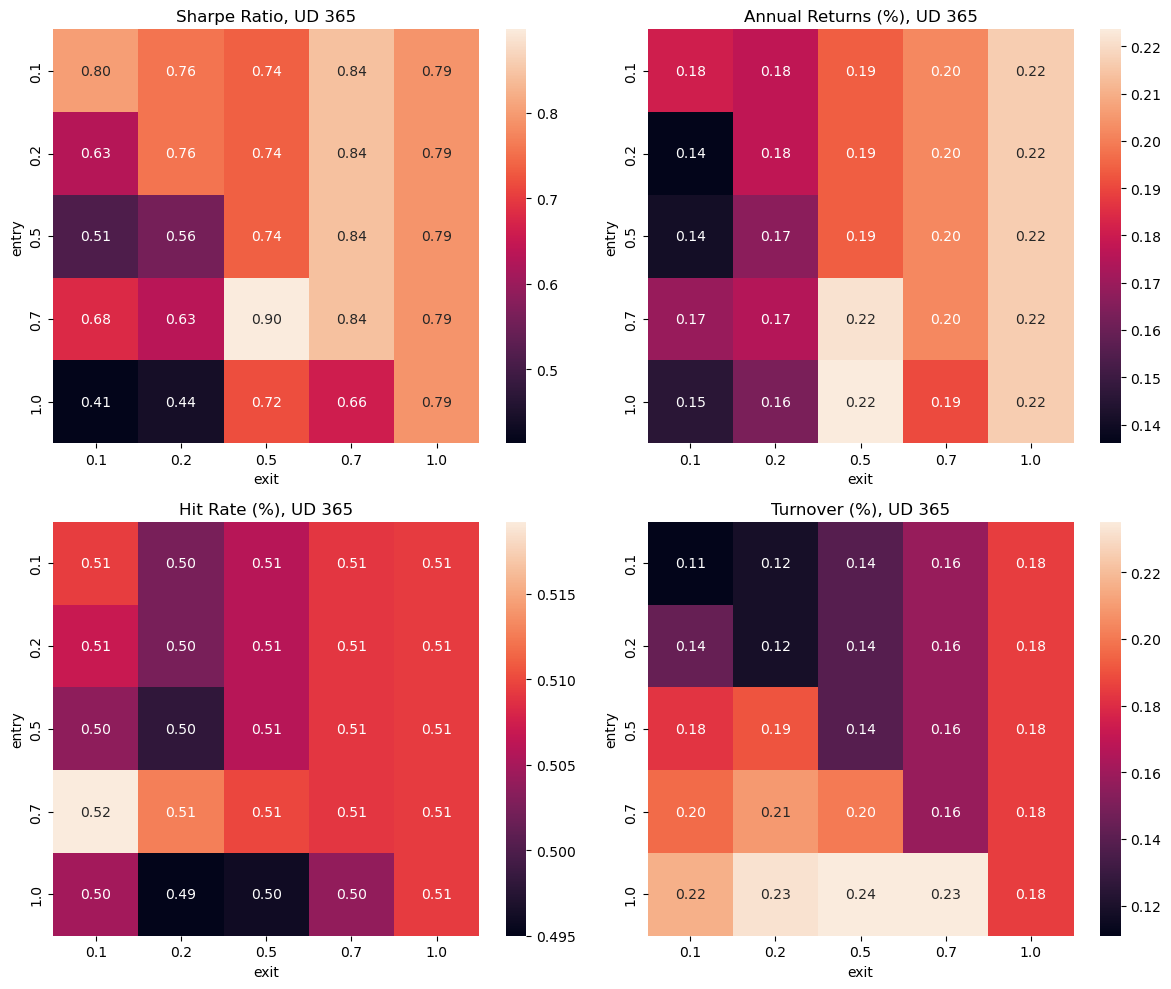

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    4.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    6.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.8s finished


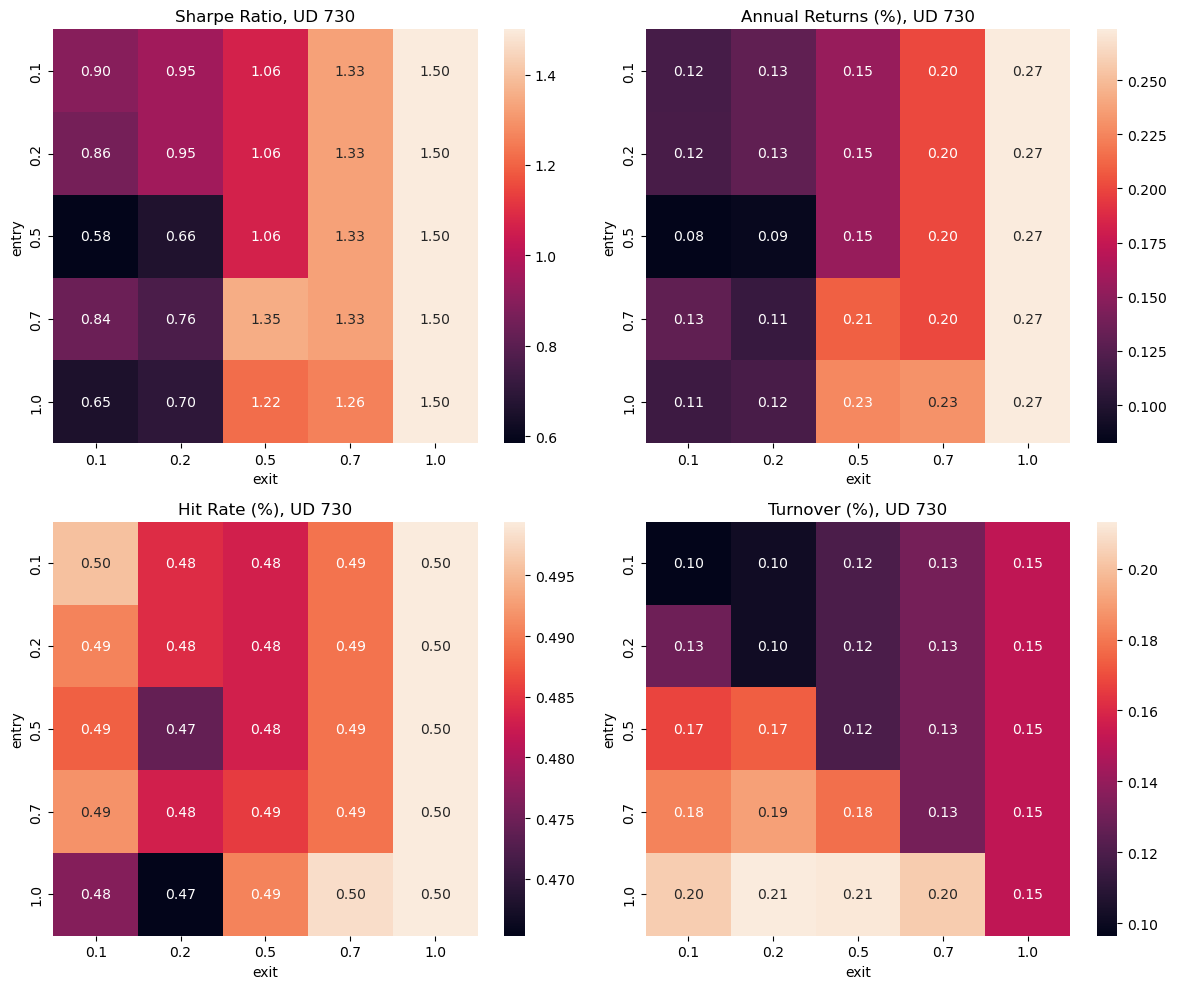

In [16]:
# parameter grids
entry_grid  = [0.1, 0.2, 0.5, 0.7, 1]
exit_grid   = [0.1, 0.2, 0.5, 0.7, 1]
update_days = [60, 90, 180, 365, 730]

open('data/metrics_results_correlation.txt','w').close()

for upd in update_days:
    # grids to store metrics 
    sharpe_grid   = pd.DataFrame(index=entry_grid, columns=exit_grid, dtype=float)
    return_grid   = pd.DataFrame(index=entry_grid, columns=exit_grid, dtype=float)
    hitrate_grid  = pd.DataFrame(index=entry_grid, columns=exit_grid, dtype=float)
    turnover_grid = pd.DataFrame(index=entry_grid, columns=exit_grid, dtype=float)

   # walk forward backtest for each entry/exit in this update window
    tasks = [(e, x) for e, x in product(entry_grid, exit_grid)]

    results = Parallel(n_jobs=-1, verbose=5)(
        delayed(lambda e, x: (
            e, x,
            walk_forward_backtest(data, x, e, upd)
        ))(e, x)
        for e, x in tasks
    )

    # sequentially write and fill grids
    with open('data/metrics_results_correlation.txt','a') as f:
        f.write(f"\n\n=== update_days = {upd} ===\n")
        for e, x, df_folds in results:
            f.write(f"\n-- entry={e}, exit={x} --\n")
            f.write(df_folds.to_string())
            f.write("\n")

            sharpe_grid.loc[e, x] = df_folds['sharpe'].mean()
            return_grid.loc[e, x] = df_folds['mean'].mean()
            hitrate_grid.loc[e, x] = df_folds['hit_rate'].mean()
            turnover_grid.loc[e, x] = df_folds['turnover'].mean()

    # plot heatmap for this update window
    plot_heatmaps(sharpe_grid, return_grid, hitrate_grid, turnover_grid, upd)


we can see that update windows of 720 and 180 have good sharpe ratios but 720 days is too long of a window for this specific strategy hence we will use a window of 180 days (6 months) and have an entry/exit of 1/0.2

# Optimal Strategy

In [17]:
end_date = pd.Timestamp(data.index[-1])

In [18]:
# popular coins to buy and hold 
btc_bh = coin_returns['BTC'].loc[test.index].cumsum()
xrp_bh = coin_returns['XRP'].loc[test.index].cumsum()
bnb_bh = coin_returns['BNB'].loc[test.index].cumsum()

In [19]:
# defining the update days 
upd_freq = '6MS'
update_days = pd.date_range(start=test.index.min(), end=end_date, freq=upd_freq)
update_days

DatetimeIndex(['2020-01-01', '2020-07-01', '2021-01-01', '2021-07-01',
               '2022-01-01', '2022-07-01', '2023-01-01', '2023-07-01',
               '2024-01-01', '2024-07-01'],
              dtype='datetime64[ns]', freq='6MS')

In [20]:
entry, exit = 1, 0.2   
tcost = 20  # transcation costs in bpts 

# will hold daily pnl from each rolling test window 
all_net = pd.Series(dtype=float)
# holds every days portfolio weight
full_pos = pd.DataFrame(index=test.index, columns=test.columns, dtype=float)

for start in update_days:

    # defining train/test boundries 
    train_start = start - pd.DateOffset(years=2)
    train_end = start - pd.DateOffset(days=1)

    # test slice ends 3 months later (or at end of test)
    test_end = min(start + pd.DateOffset(months=6) - pd.DateOffset(days=1), test.index.max())

    # defining train and test sets 
    historic = data.loc[train_start:train_end]
    future  = test.loc[start:test_end]


    # getting pairs from training data 
    pairs = pairs_selection(historic)

    # getting indicators 
    comb =  pd.concat([historic, future], axis=0)
    indics = compute_pair_indicators(comb, pairs).loc[future.index]

    # uncomment to visualise trades - takes a while
    # pair0 = pairs[0]
    # plot_pair_signals(indics, (pair0[0],pair0[1]), exit, entry)

    # getting positions 
    pos = gen_positions(indics, pairs, future, exit, entry)    

    # simple returns 
    simple = future / future.shift() - 1

    # calculating gross and net returns 
    gross_returns = (pos.shift() * simple).sum(axis=1)
    cost = turnover(pos) * tcost * 1e-4
    net_returns = gross_returns.subtract(cost, fill_value=0)
    
    # append returns 
    all_net = pd.concat([all_net, net_returns])
    # add this windows weight to full_pos
    full_pos.loc[future.index] = pos

all_net = all_net.sort_index().loc[~all_net.index.duplicated()] # sorts and drops duplicate timestamps 
full_pos = full_pos.ffill().loc[all_net.index]  # forward fill 


In [21]:
# getting statistics for the strategy 
strat_stats = stats(all_net)
mean_to   = turnover(full_pos).mean()
hold_days = 2 / mean_to

In [22]:
# displaying stats 
display_stats((entry,exit), strat_stats['sharpe'], strat_stats['mean'], strat_stats['vol'], mean_to, strat_stats['hit_rate'] ,hold_days, upd_freq)

e = 1, x = 0.2, upd : 6MS
Annual Return                        28.98%
Annual Volatility                    22.43%
Sharpe Ratio                           1.29
Annual Turnover                      23.52%
Hit Rate                             51.48%
Holding Period                     8.5 days

In [23]:
cum_strat  = (1+all_net).cumprod()-1

# Plotting equity curve

In [24]:
df_cum = pd.DataFrame({
    "Pairs Strategy":    cum_strat,
    "BTC B/H":           btc_bh,
    "XRP B/H":           xrp_bh,
    "BNB B/H":           bnb_bh,})

df_plot = (df_cum.reset_index().rename(columns={"index": "Date"}).melt(
         id_vars="Date",
         var_name="Strategy",
         value_name="Cumulative Return")
)

fig = px.line(df_plot, x="Date", y="Cumulative Return", color="Strategy",
    title=f"Equity Curves (entry={entry}, exit={exit}, 6-mo updates)",
    labels={"Date":"Date", "Cumulative Return":"Cumulative Return"}
)
fig.update_layout(hovermode="x unified")
fig.show()

we can see this strategy does well, it outperforms bh BTC and XRP (which are popular coins to buy and hold) but falls short of bh BNB. We get an annual return of 29% with a sharpe ratio of 1.3 so overall this works decently well.